<a href="https://colab.research.google.com/github/ondraperny/BI-BPR-2019/blob/master/Data_preprocessor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessor
Modul for preprocessing data. To simplify different types of preprocessed data.

Function:

**Copy whole content(subdirs recursively) to new path while applying filters co copied pictures.**

In [1]:
import sys
# check if code run on colab or local
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Mount google drive
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**PATH_ORIGIN**      is path to directory with input data

**PATH_DESTINATION** is path to directory where copy of transformed data will be saved(file structure of transformed dir will remain same)

If we dont want to create copy, just transform data, then set PATH_DESTINATION same as PATH_ORIGIN.

In [0]:
PATH_ORIGIN= "/content/drive/My Drive/SKOLA/Bachelor_work/XR_HUMERUS/"

COMMON_PATH = "/content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/"

PATH_DESTINATION_CROPPED_RECT = COMMON_PATH + "cropped_rect/"
PATH_DESTINATION_CROPPED_SQUARE = COMMON_PATH + "cropped_square/"

PATH_DESTINATION_HIST_EQ = COMMON_PATH + "hist_eq/"
PATH_DESTINATION_CLAHE = COMMON_PATH + "clahe/"

# cropped_rect_clahe shows so far best results
PATH_DESTINATION_CROPPED_RECT_CLAHE = COMMON_PATH + "cropped_rect_clahe/"
PATH_DESTINATION_CROPPED_SQUARE_CLAHE = COMMON_PATH + "cropped_square_clahe/"

PATH = PATH_DESTINATION_CROPPED_SQUARE

DEBUG_ON = True

### Data transformation class
currently only class with all required methods

In [0]:
from PIL import Image
from pathlib import Path
import numpy as np
import os
import IPython.display

class DataTransformation():
  """Encapsulate functions that are neccesary for processing images
  and handling file structure
  
  Attributes
  ----------
  PATH_ORIGIN : str
    valid path to dir with input data
  PATH_DESTINATION : str
    path to dir with output data (path does not have to exist yet)

  Methods
  -------
  correct_dir_path(path)
    If path string does not end with '\', it adds it to the path
  change_path(old_path, destination_path, file_path)
    Change path of file from old dir to a new one
  generate_subdirs(in_path)
  generate_image_paths(dir_path)
  open_image(image_path, return_in_PIL_format = False)
  save_image(image_numpy_array, path_to_dir, image_name)
  show_images(*images)
  copy_imgs_apply_filters(self, max_images_per_dir, *filters)
    Loads images from from PATH_ORIGIN, pply every filter function to an images
    and save in same file structure
  check_file_exists(img)
  """

  def __init__(self, PATH_ORIGIN, PATH_DESTINATION):
    if not IN_COLAB:
      PATH_ORIGIN =      "G:"+PATH_ORIGIN[14:].replace('/', '\\\\')
      PATH_DESTINATION = "G:"+PATH_DESTINATION[14:].replace('/', '\\\\')
    self.PATH_ORIGIN = PATH_ORIGIN
    self.PATH_DESTINATION = PATH_DESTINATION

  def correct_dir_path(self, path):
    """check if string is correct path to directory - ends with slash
    if it doesn't, it adds it
    @return correct path"""
    if path[-1] != '/' and IN_COLAB:
      path = path + '/'
    elif path[-1] != '\\' and not IN_COLAB:
      path = path + '\\'
    return path

  def change_path(self, old_path, destination_path, file_path):
    """take file_path, trim old_path from it and add destination_path instead"""
    old_path = self.correct_dir_path(old_path)
    old_path_len = len(old_path)
    # cut off prefix(old_path) from file_path
    dir_path_from_current = str(file_path)[old_path_len:]
    destination_path = self.correct_dir_path(destination_path)
    return destination_path + dir_path_from_current

  @staticmethod
  def generate_subdirs(dir_path):
    """Return generator to all subdirectories of in_path"""
    for path in Path(dir_path).glob("**"):
      yield path

  @staticmethod
  def generate_image_paths(dir_path):
    """Generator with path to every png image in specified dir"""
    for image in Path(dir_path).glob("*.png"):
      yield image

  @staticmethod
  def open_image(image_path, return_in_PIL_format = False):
    """Open image, based on parameter return image type"""
    try:
      image_PIL = Image.open(image_path).convert('L')
      if return_in_PIL_format:
        return image_PIL
      else:
        return np.array(image_PIL)
    except:
      print("Can't open image \"" + str(image_path) + "\"")

  def save_image(self, image_numpy_array, path_to_dir, image_name):
    """Save image to specified path, with specified name"""
    path_to_dir = self.correct_dir_path(path_to_dir)
    image = Image.fromarray(image_numpy_array)
    image.save(path_to_dir+image_name)
    print("Image " + image_name + " saved in " + path_to_dir)

  @staticmethod
  def show_images(*images):
    for img in images:
      IPython.display.display(Image.fromarray(img))

  def copy_imgs_apply_filters(self, max_images_per_dir, *filters):
    """Create directories in new path and copy all images in those directories, as well
    apply filter on image
    
    Parameters
    ----------
    max_images_per_dir : int
      maximum amount of processed images per directory, by default (= 0) process
      every image found
    """

    for directory in self.generate_subdirs(self.PATH_ORIGIN):
      # Create target directory & all intermediate directories if don't exists
      new_path = self.change_path(self.PATH_ORIGIN, self.PATH_DESTINATION, directory)
      # print(new_path)
      try:
        os.makedirs(new_path)    
        print("Directory created: " , new_path)
      except FileExistsError:
        print("Directory already exists: " , new_path)
      
      cnt = 0
      for image_path in self.generate_image_paths(directory):
        new_image_path = self.correct_dir_path(new_path) + Path(image_path).name
        if self.check_file_exists(new_image_path) and not DEBUG_ON:
          print("File already exists: " + new_image_path)
        else:
          image = self.open_image(image_path)
          try:
            for filter in filters:
              image = filter(image)          
            self.save_image((image), new_path, Path(image_path).name)
          except ValueError as ve:
            print("File could not be processed: ", image_path)


        if max_images_per_dir == 0:
          continue
        elif cnt >= max_images_per_dir:
          break
        else:
          cnt = cnt + 1

    print("All images were processed.")

  @staticmethod
  def check_file_exists(path):
    return Path(path).is_file()


### Support functions for processing images
Encapsulated in class ImageProcessing

In [0]:
import cv2

class ImageProcessing:
  """Encapsulate all image processing functions
  
  Methods
  -------
  rotate_img_if_needed(img)
  crop_rectangle(rect, src)
  revert_mask_if_needed(img_mask)
  erode(img)
  dilate(img)
  find_contour(ref_mask)
  draw_contour(image, contours)
  otsu_thresh_after_gauss(img)
  """

  @staticmethod
  def add_border(img, border_type=cv2.BORDER_CONSTANT, border_size=100):
    """Adds border to image, by default constant black color, with border width 100px""" 
    img_border = cv2.copyMakeBorder(
      img,
      top=border_size,
      bottom=border_size,
      left=border_size,
      right=border_size,
      borderType=border_type,
      value=[0, 0, 0]
      )
    return img_border

  @staticmethod
  def rotate_img_if_needed(img):
    """If width of image is bigger than his height, it is rotated to left by 90"""
    h, w = img.shape[0:2]
    if DEBUG_ON:
      print("Rotated image shape, height:", h, ",width:", w)
    if w > h:
      return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img

  @staticmethod
  def crop_rectangle(rect, src):
    """Cut rotated rectangle from src image"""
    # Get center, size, and angle from rect
    center, size, theta = rect
    # Convert to int 
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D( center, theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(src, M, (src.shape[0],src.shape[1]))
    out = cv2.getRectSubPix(dst, size, center)
    return out
    
  @staticmethod
  def revert_mask_if_needed(img_mask):
    h, w = img_mask.shape[0:2]
    bottom_right = img_mask[h-1, w-1]
    bottom_left = img_mask[0, w-1]
    upper_left = img_mask[0, 0]
    upper_right = img_mask[h-1, 0]
    if int(bottom_right) + int(bottom_left) + int(upper_left) + int(upper_right) > 255:
      img_mask = 255 - img_mask
    if DEBUG_ON:
      # print(h, w)
      print("Colors in corners(0 - black) bottom_right, bottom_left, upper_left, upper_right:", h-1, w-1, 0, w-1, 0, 0, h-1, 0)
      print(bottom_right, bottom_left, upper_left, upper_right)
      print(int(bottom_right) + int(bottom_left) + int(upper_left) + int(upper_right))
    return img_mask

  # during erosion white part is reduced
  @staticmethod
  def erode(img):
    kernel = np.ones((10,10),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 3)
    return erosion

  # during dilation white part is increased (background is black)
  @staticmethod
  def dilate(img):
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = 2)
    return dilation

  @staticmethod
  def find_contour(ref_mask):
    """find all contours of image"""
    contours, hierarchy = cv2.findContours(ref_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if DEBUG_ON:
      print(f'Found {len(contours)} contours.')
    return contours

  @staticmethod
  def draw_contour(image, contours):
    """draw contours onto an image"""
    contour_drawn = cv2.drawContours(image.copy(), contours, -1, color=(255, 0, 0 ), thickness=10)
    if DEBUG_ON:
      cv2_imshow(contour_drawn)

  #https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
  @staticmethod
  def otsu_thresh_after_gauss(img):
    """Otsu's thresholding after Gaussian filtering"""
    blur = cv2.GaussianBlur(img,(5,5),0)
    _, th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

### Specific filters that can be used on data
Encapsulated in class ImageFilters

In [0]:
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

class ImageFilters:
  """Encapsulate all image filter functions
  
  Methods
  -------
  smoother(img)
  histogram_equalization(img)
    apply histogram equalization on image
  clahe(img)
    apply clahe on image
  crop_ROI_rect(img)
    find region of interest (bone in x-rays) and cut the smallest rotated
    rectangle, image is rotated so bone is straight up (result of cropping rotatedRect)
  crop_ROI_square_224(img)
    find region of interest (bone in x-rays) and cut 244x244 pixels image 
    from center of the region of interest
  """

  @staticmethod
  def smoother(img):
    """smoother the image"""
    kernel = np.ones((5,5),np.float32)/25
    return cv2.filter2D(img,-1,kernel)

  @staticmethod
  def histogram_equalization(img):
    """Spread most frequent intensity values, creating better contrast image"""
    return cv2.equalizeHist(img)
  
  @staticmethod
  def clahe(img):
    """Contrast limited adaptive histogram equalization - works with adaptive
    areas with small contrast amplification"""
    clahe =  cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)

  @staticmethod
  def crop_ROI_rect(img):
    """TODO: perfect dilating picture and then properly cut ROI zones from
    pictures"""
    if DEBUG_ON:
      cv2_imshow(img)

    img_mask = ImageProcessing.otsu_thresh_after_gauss(img)
    img_mask = ImageProcessing.erode(img_mask)
    img_mask = ImageProcessing.dilate(img_mask)
    img_mask = ImageProcessing.revert_mask_if_needed(img_mask)
    border = ImageProcessing.add_border(img_mask)
    
    if DEBUG_ON:
      cv2_imshow(border)
    
    img = ImageProcessing.add_border(img, cv2.BORDER_DEFAULT)

    if DEBUG_ON:
      cv2_imshow(img)

    contours = ImageProcessing.find_contour(border)
    cont = np.vstack(contours)
    hull = cv2.convexHull(cont)

    rect = cv2.minAreaRect(hull)

    # box = cv2.boxPoints(rect)
    # box = np.int0(box)
    # cv2.drawContours(img, [box], 0, (0, 0, 255))
    
    img = ImageProcessing.crop_rectangle(rect, img)
    img = ImageProcessing.rotate_img_if_needed(img)
    
    if DEBUG_ON:
      print("Box containment:", box)
      cv2_imshow(img)
      print("------------------------------------------------------------------------------")
      
    return img

  @staticmethod
  def resize_img_224(img):
    return cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA) 

  # todo zkusit bez rotace pak mozna crop s rotaci

  @staticmethod
  def crop_ROI_square_224(img):
    """TODO: perfect dilating picture and then properly cut ROI zones from
    pictures"""
    if DEBUG_ON:
      cv2_imshow(img)

    img_mask = ImageProcessing.otsu_thresh_after_gauss(img)
    img_mask = ImageProcessing.erode(img_mask)
    img_mask = ImageProcessing.dilate(img_mask)
    img_mask = ImageProcessing.revert_mask_if_needed(img_mask)
    border = ImageProcessing.add_border(img_mask)

    if DEBUG_ON:
      cv2_imshow(border)

    img = ImageProcessing.add_border(img, cv2.BORDER_DEFAULT)

    # find contours and create convex hull object from them
    contours = ImageProcessing.find_contour(border)
    cont = np.vstack(contours)
    hull = cv2.convexHull(cont)

    # find moments of convex hull
    moments = cv2.moments(hull)
    X_coord = int(moments["m10"] / moments["m00"])
    Y_coord = int(moments["m01"] / moments["m00"])

    # maximal distance from center - resulting in 224x224 image
    max_dist = 112
    img = img[Y_coord-max_dist:Y_coord+max_dist,
              X_coord-max_dist:X_coord+max_dist]

    if DEBUG_ON:
      cv2.circle(img, (X_coord, Y_coord), 5, (255, 255, 255), -1) 
      print("x, y:", X_coord, Y_coord)
      cv2_imshow(img)
      print("------------------------------------------------------------------------------")

    return img


Directory already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/
Directory already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/train
Directory already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/train/train_negative


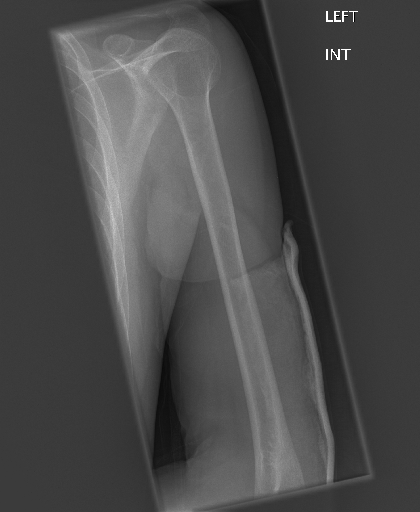

Colors in corners(0 - black) bottom_right, bottom_left, upper_left, upper_right: 511 419 0 419 0 0 511 0
0 0 0 0
0


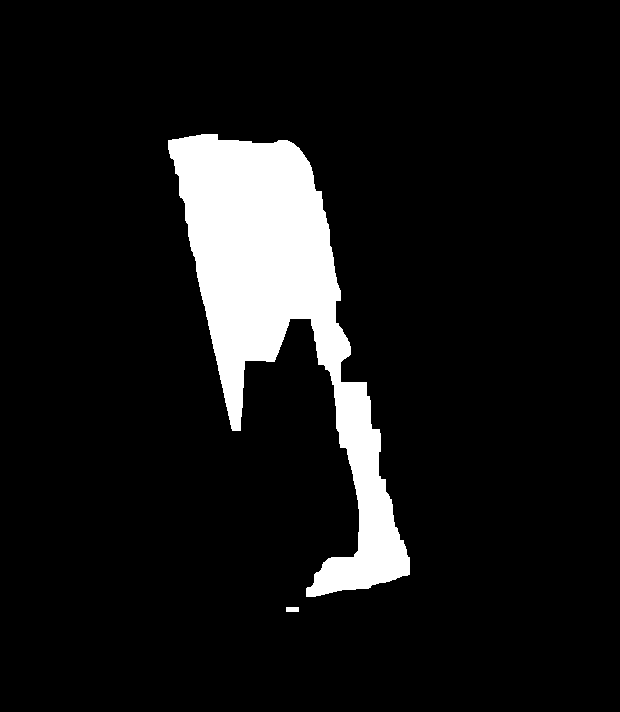

Found 2 contours.
x, y: 289 365


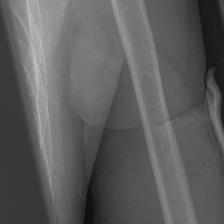

------------------------------------------------------------------------------
Image 214.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/train/train_negative/


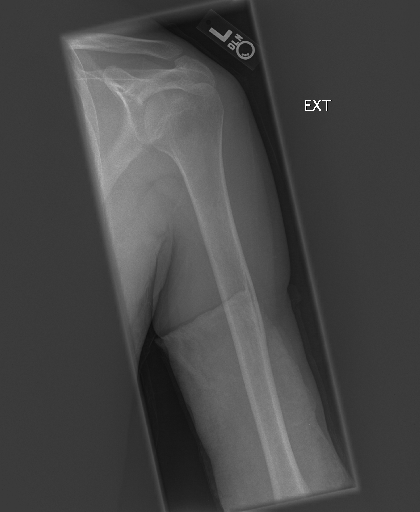

Colors in corners(0 - black) bottom_right, bottom_left, upper_left, upper_right: 511 419 0 419 0 0 511 0
0 0 0 0
0


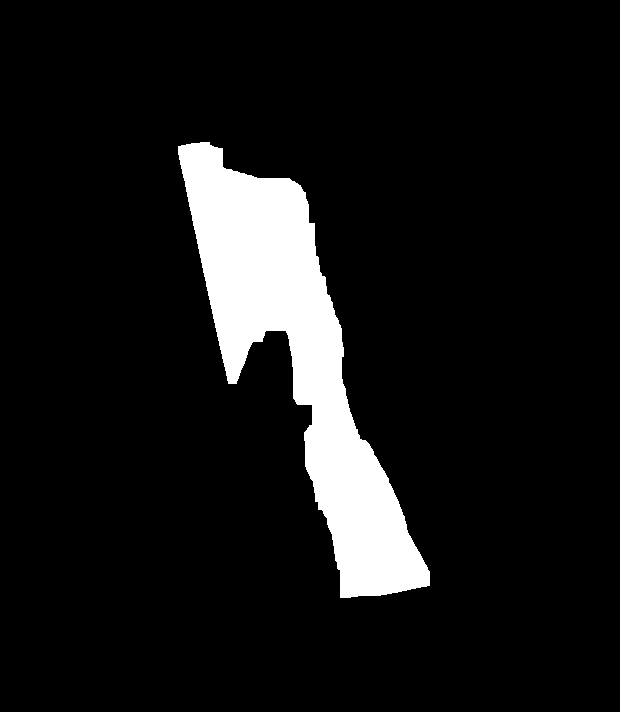

Found 1 contours.
x, y: 299 369


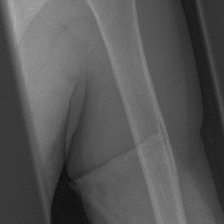

------------------------------------------------------------------------------
Image 215.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/train/train_negative/
Directory already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/train/train_positive


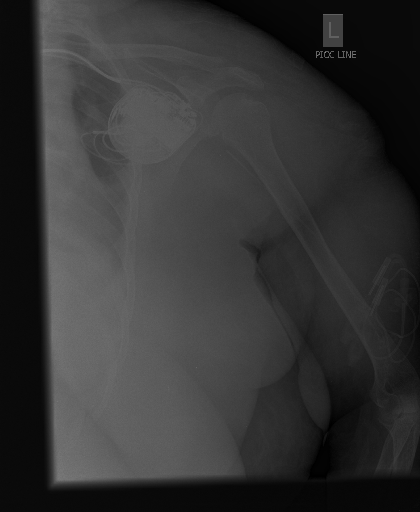

Colors in corners(0 - black) bottom_right, bottom_left, upper_left, upper_right: 511 419 0 419 0 0 511 0
0 0 0 0
0


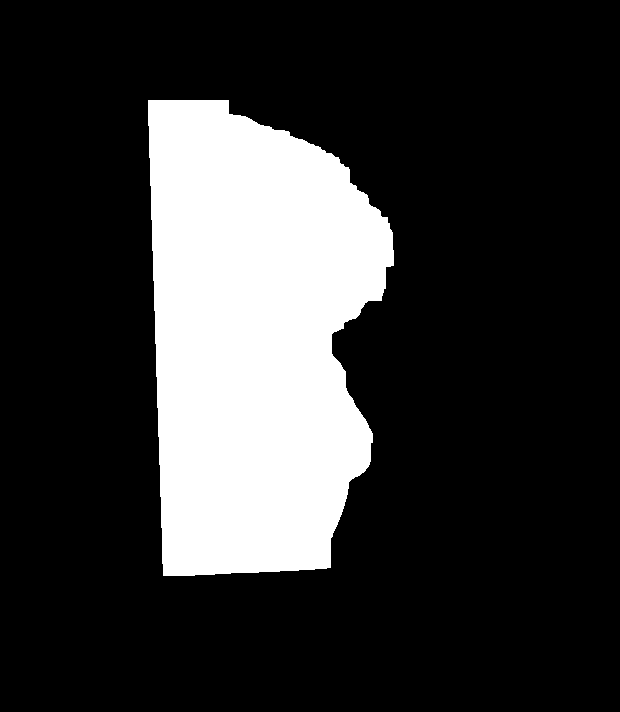

Found 1 contours.
x, y: 260 338


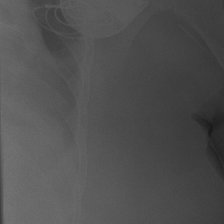

------------------------------------------------------------------------------
Image 139.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/train/train_positive/


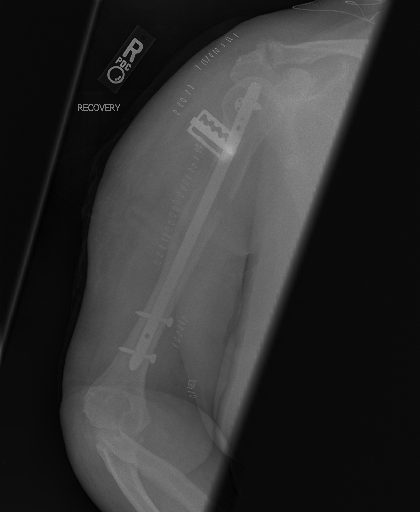

Colors in corners(0 - black) bottom_right, bottom_left, upper_left, upper_right: 511 419 0 419 0 0 511 0
0 0 0 0
0


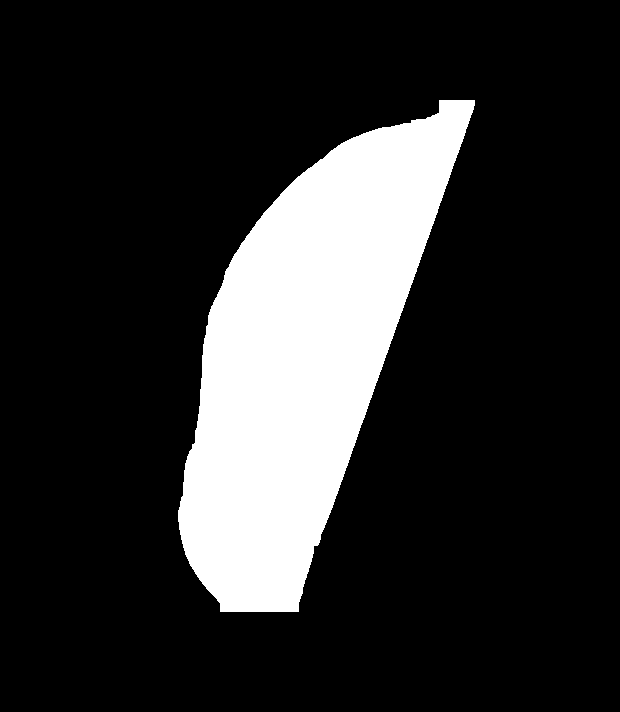

Found 1 contours.
x, y: 305 354


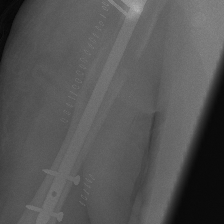

------------------------------------------------------------------------------
Image 140.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/train/train_positive/
Directory already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/valid
Directory already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/valid/valid_negative


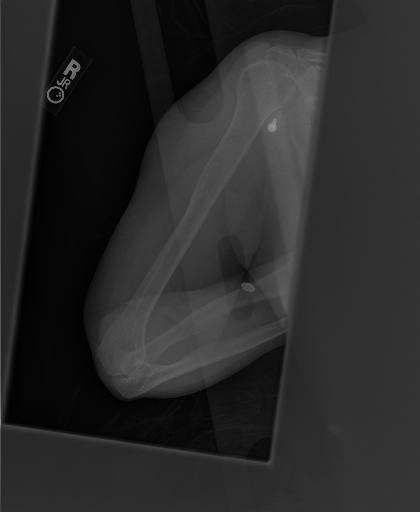

Colors in corners(0 - black) bottom_right, bottom_left, upper_left, upper_right: 511 419 0 419 0 0 511 0
255 255 255 255
1020


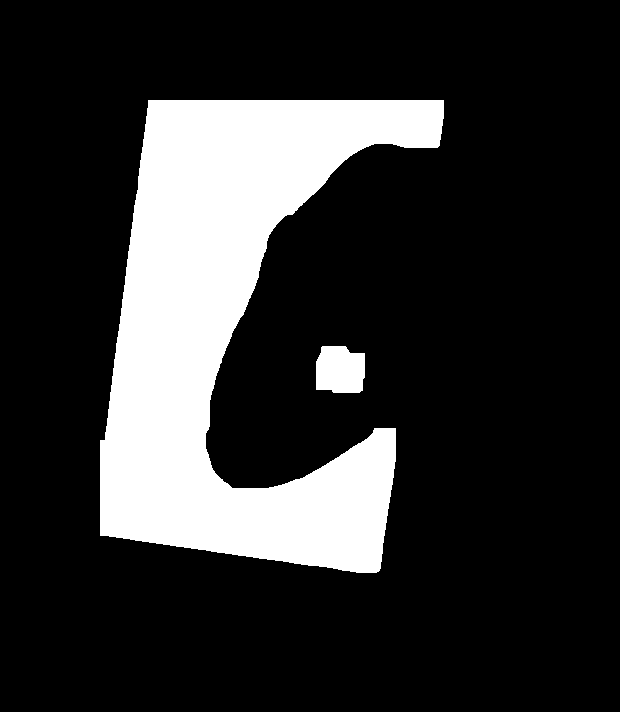

Found 2 contours.
x, y: 267 326


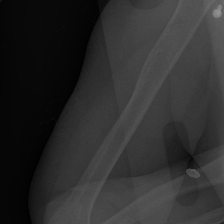

------------------------------------------------------------------------------
Image 0.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/valid/valid_negative/


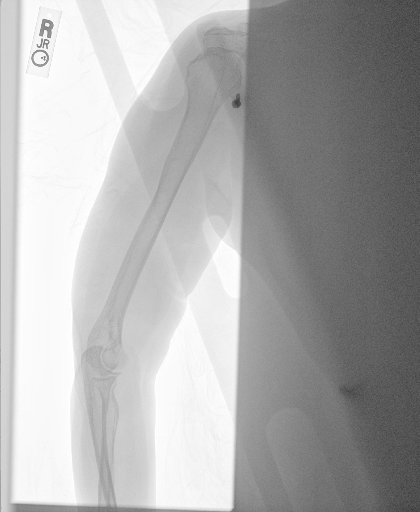

Colors in corners(0 - black) bottom_right, bottom_left, upper_left, upper_right: 511 419 0 419 0 0 511 0
0 0 255 0
255


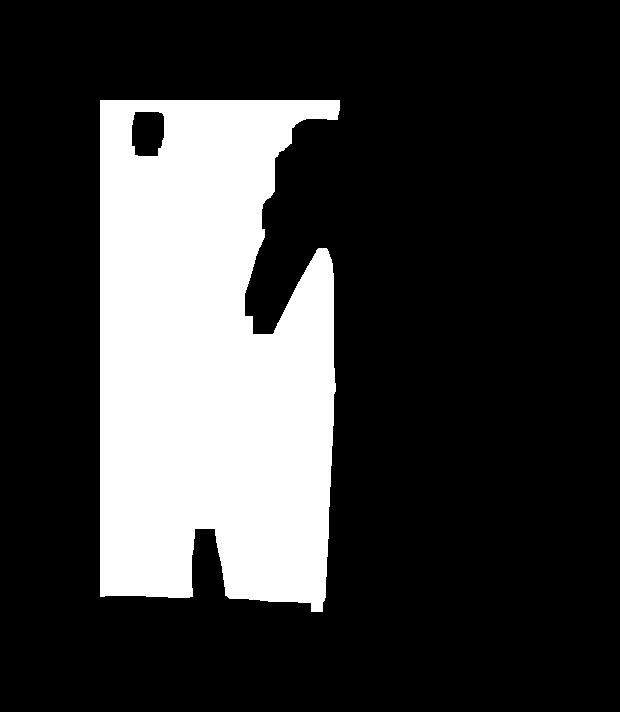

Found 2 contours.
x, y: 217 349


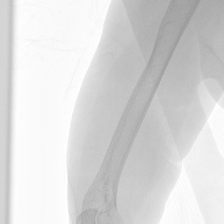

------------------------------------------------------------------------------
Image 1.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/valid/valid_negative/
Directory already exists:  /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/valid/valid_positive


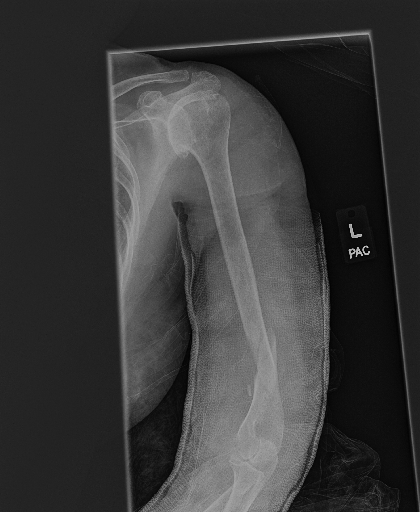

Colors in corners(0 - black) bottom_right, bottom_left, upper_left, upper_right: 511 419 0 419 0 0 511 0
0 0 0 0
0


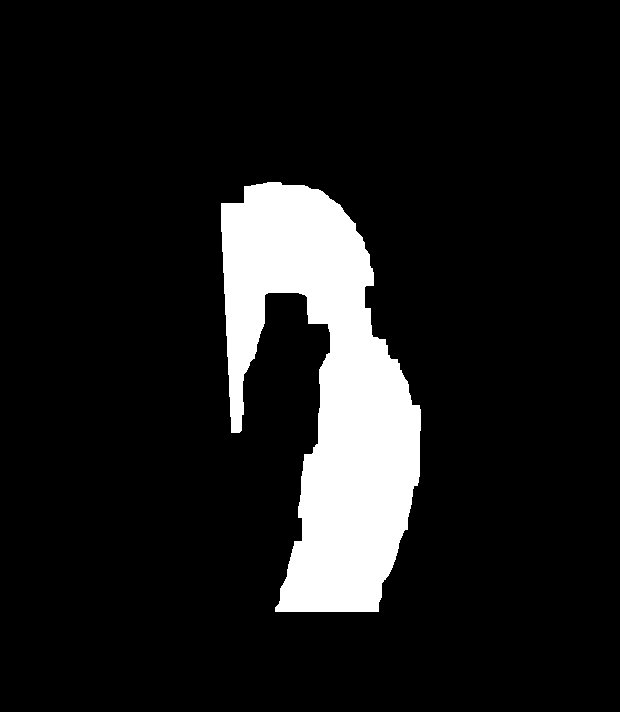

Found 1 contours.
x, y: 316 398


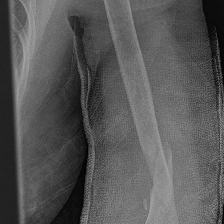

------------------------------------------------------------------------------
Image 0.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/valid/valid_positive/


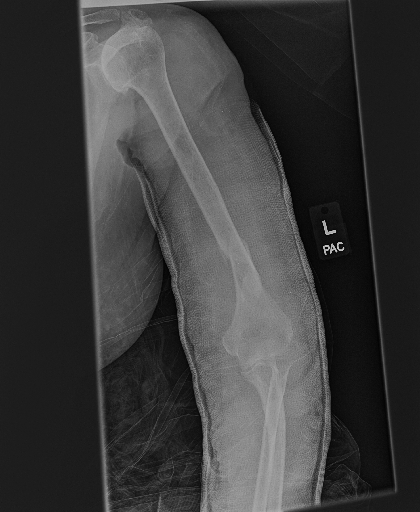

Colors in corners(0 - black) bottom_right, bottom_left, upper_left, upper_right: 511 419 0 419 0 0 511 0
0 0 0 0
0


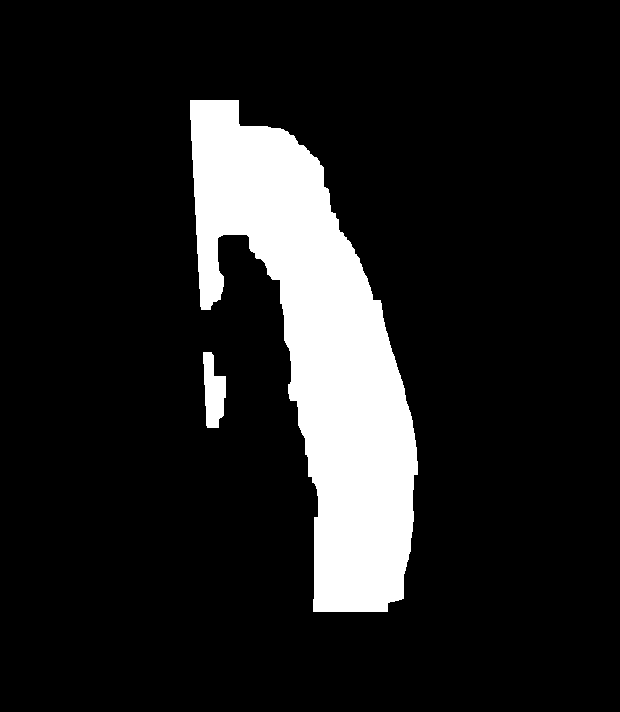

Found 2 contours.
x, y: 300 362


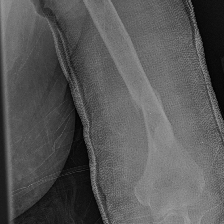

------------------------------------------------------------------------------
Image 1.png saved in /content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/cropped_square/valid/valid_positive/
All images were processed.


In [6]:
# init required classes
trans = DataTransformation(PATH_ORIGIN, PATH)
filters = ImageFilters()

trans.copy_imgs_apply_filters(1, ImageFilters.crop_ROI_square_224)